# comp478 - final project

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/Happyduck93/non-local-algorithm.git

Cloning into 'non-local-algorithm'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 719.19 KiB | 1.91 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
!dir

non-local-algorithm  sample_data


In [4]:
%cd non-local-algorithm/

/content/non-local-algorithm


## Prepare noisy lena image

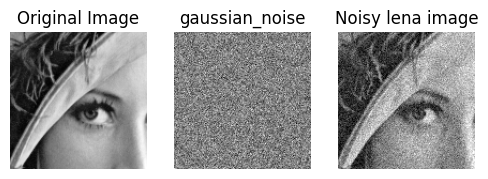

In [5]:
# Load lena image in grayscale
lena_image = cv2.imread('lena_color.tiff', cv2.IMREAD_GRAYSCALE)

# Define starting point and size of resulting image
x, y, w, h = 190, 190, 128, 128

# Crop the image
lena_image = lena_image[y:y+h, x:x+w]

# Standard deviation
sigma =20

# Generate Gaussian noise
gaussian_noise = np.random.normal(0, sigma, lena_image.shape)

# Add the Gaussian noise to the image
noisy_lena_image = lena_image + gaussian_noise

# Clip the values to stay within valid range for grayscale
noisy_lena_image = np.clip(noisy_lena_image, 0, 255)

# Convert back to uint8
noisy_image = noisy_lena_image.astype(np.uint8)

# Display images
plt.figure(figsize=(6, 2))

# Original grayscale image
plt.subplot(1, 3, 1)
plt.imshow(lena_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Gaussian noise with standard deviation 20
plt.subplot(1, 3, 2)
plt.imshow(gaussian_noise, cmap='gray')
plt.title('gaussian_noise')
plt.axis('off')


# Original + Gaussian noise
plt.subplot(1, 3, 3)
plt.imshow(noisy_lena_image, cmap='gray')
plt.title('Noisy lena image')
plt.axis('off')

plt.show()

## Guassian filtering (Local denoising)

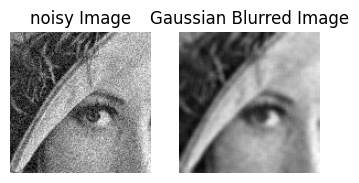

In [6]:
# Apply Gaussian blur
kernel_size = (5, 5)
sigma = 20  # standard deviation (sigma)
gaussian_blurred_lena_image = cv2.GaussianBlur(noisy_lena_image, kernel_size, sigma)

# Display images
plt.figure(figsize=(4,2))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(noisy_lena_image, cmap='gray')
plt.title('noisy Image')
plt.axis('off')

# Blurred image
plt.subplot(1, 2, 2)
plt.imshow(gaussian_blurred_lena_image, cmap='gray')
plt.title('Gaussian Blurred Image')
plt.axis('off')

plt.show()


### Method noise for guassian filtering

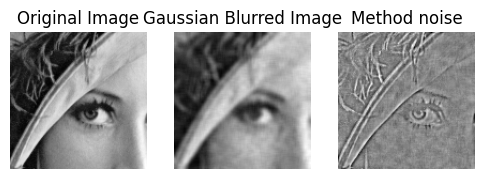

In [7]:
# Gaussian Method noise
Method_gaussian = lena_image - gaussian_blurred_lena_image

# Display images
plt.figure(figsize=(6,2))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(lena_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Gaussian blurred image
plt.subplot(1, 3, 2)
plt.imshow(gaussian_blurred_lena_image, cmap='gray')
plt.title('Gaussian Blurred Image')
plt.axis('off')

# Gaussian Method noise
plt.subplot(1, 3, 3)
plt.imshow(Method_gaussian, cmap='gray')
plt.title('Method noise')
plt.axis('off')

plt.show()

## Total variation minimization - Chambolle (local denoising)

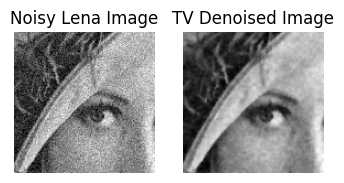

In [8]:
from skimage import restoration

# Apply TV denoising
tv_denoised = restoration.denoise_tv_chambolle(noisy_lena_image, weight=25)

# Display images
plt.figure(figsize=(4,2))

# Noisy lena image
plt.subplot(1, 2, 1)
plt.imshow(noisy_lena_image, cmap='gray')
plt.title('Noisy Lena Image')
plt.axis('off')

# TV denoised image
plt.subplot(1, 2, 2)
plt.imshow(tv_denoised, cmap='gray')
plt.title('TV Denoised Image')
plt.axis('off')

plt.show()


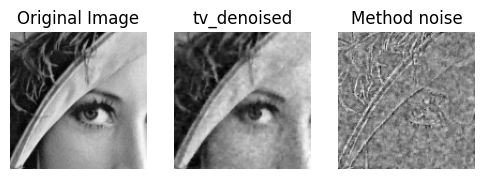

In [9]:
# TV method noise
method_tv = lena_image - tv_denoised

# Display images
plt.figure(figsize=(6,2))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(lena_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# TV denoised image
plt.subplot(1, 3, 2)
plt.imshow(tv_denoised, cmap='gray')
plt.title('tv_denoised')
plt.axis('off')

# TV Method noise
plt.subplot(1, 3, 3)
plt.imshow(method_tv, cmap='gray')
plt.title('Method noise')
plt.axis('off')

plt.show()

# Non-Local means algorithm

In [10]:
def non_local_means_denoising(image, std=0.6,ps=3,wps=10):
    """

    :param image: 128*128 lena image
    :type param1: numpy.ndarray

    :param std: standard deviation used to calculate filtering parameter h
    :type param2: float

    :param ps: square neighbour padding size
    :type param2: int

    :param std: seaerch window padding size
    :type param2: int


    :return: denoised image
    :rtype: numpy.ndarray
    """
    rows, cols = image.shape
    denoised_image = np.zeros((rows, cols), dtype=np.float32) #128*128

    padded_image = np.pad(image, wps + ps, mode='symmetric') # 154*154

    # for each image pixel index 13~141 (128*128)
    for i in range(wps + ps, rows + wps+ ps):
        for j in range(wps + ps, cols + wps +ps):

            # Define the 27*27 window. This is 21*21 window with padding of 3 for current pixel at center
            window_i_wp = padded_image[i -(wps+ps) : i + (wps+ps)+ 1,
                                          j - (wps+ps) : j + (wps+ps) + 1]


            window_i = padded_image[i -wps : i + wps+ 1,
                                          j - wps : j + wps + 1]

            # Define the 7*7 square neighborhood for current pixel at center
            neighborhood_i = padded_image[i - ps : i + ps + 1,
                                          j - ps : j + ps + 1]

            # Compute weights. This make 21*21 weights associated with current pixel
            raw_weights = compute_weights(window_i_wp, neighborhood_i,ps, std)


            # Normalize
            weights= raw_weights/ np.sum(raw_weights)

            # Update denoised pixel value. i and j are the position of padded image, need to update accordingly
            denoised_image[i - (wps+ps), j - (wps+ps)] = np.sum(weights * window_i)

        # print progress
        if (i-ps-wps)%20 == 0:
            print(f'{i-ps-wps}/{image.shape[0]-1}')
    print(f'{i-ps-wps}/{image.shape[0]-1}')
    print('Done')
    return denoised_image

def compute_weights(window_i_wp, neighborhood_i, ps, std):

    # for every pixel within the window
    rows, cols = window_i_wp.shape

    # size 21*21
    raw_weights = np.zeros((rows-(ps*2), cols-(ps*2)), dtype=np.float32)

    # for each pixel in the 21*21 search window without padding
    for i in range(ps, rows-ps):
        for j in range(ps, cols-ps):

            # Define the 7*7 square neighborhood for each pixel in window
            neighborhood_j = window_i_wp[i - ps : i + ps + 1,
                                          j - ps : j + ps + 1]

            # Compute squared differences between neighborhoods
            diff_squared = np.sqrt(np.sum((neighborhood_i - neighborhood_j)**2))

            # Apply Gaussian function
            h = std * 10 # filtering parameter
            gf = np.exp(-diff_squared / (h)**2)

            # Compute weights
            raw_weights[i - ps, j - ps] = gf

    return raw_weights




### Apply non-local algorithm

In [11]:
nl_denoised_result = non_local_means_denoising(noisy_lena_image, std=0.6)

0/127
20/127
40/127
60/127
80/127
100/127
120/127
127/127
Done


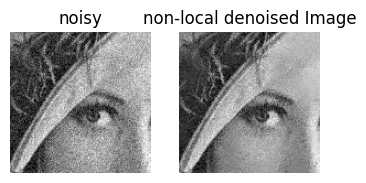

In [12]:
# Display the results
plt.figure(figsize=(4, 2))

# noisy image
plt.subplot(1, 2, 1)
plt.imshow(noisy_lena_image, cmap='gray')
plt.title('noisy')
plt.axis('off')

# non-local denoised image
plt.subplot(1, 2, 2)
plt.imshow(nl_denoised_result, cmap='gray')
plt.title('non-local denoised Image')
plt.axis('off')

plt.show()

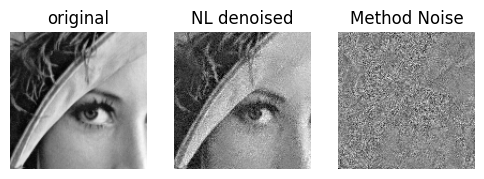

In [13]:
# non-local method noise
method_nl = lena_image - nl_denoised_result

# Display the results
plt.figure(figsize=(6, 2))

# original
plt.subplot(1, 3, 1)
plt.imshow(lena_image, cmap='gray')
plt.title('original')
plt.axis('off')

# non-local denoised
plt.subplot(1, 3, 2)
plt.imshow(nl_denoised_result, cmap='gray')
plt.title('NL denoised')
plt.axis('off')

# non-local method noise
plt.subplot(1, 3, 3)
plt.imshow(method_nl, cmap='gray')
plt.title('Method Noise')
plt.axis('off')

plt.show()

# comparison

### Denoising on a noisy image

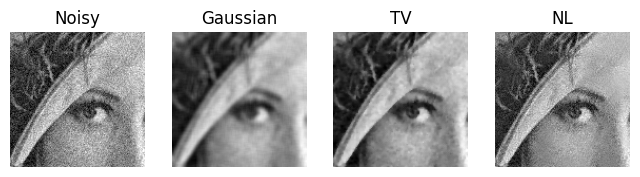

In [14]:
images = [noisy_lena_image, gaussian_blurred_lena_image, tv_denoised, nl_denoised_result]
titles = ['Noisy','Gaussian','TV','NL']


fig, axs = plt.subplots(1, 4, figsize=(8, 2))

# display each image
for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

plt.show()


### Method noise on the original image

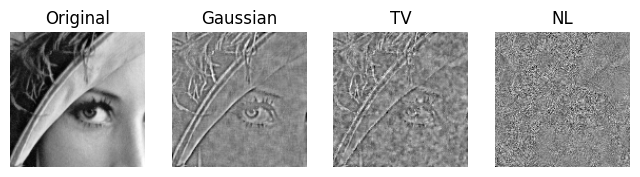

In [15]:
images = [lena_image, Method_gaussian, method_tv, method_nl]
titles = ['Original','Gaussian','TV','NL']



fig, axs = plt.subplots(1, 4, figsize=(8, 2))

# display each image
for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

plt.show()

# Parameter testing

In [16]:
nl_denoised_result_st01 = non_local_means_denoising(noisy_lena_image, std=0.1)

0/127
20/127
40/127
60/127
80/127
100/127
120/127
127/127
Done


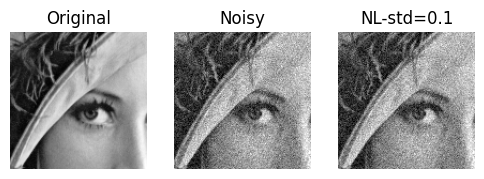

In [17]:
images = [lena_image, noisy_lena_image,nl_denoised_result_st01]
titles = ['Original','Noisy','NL-std=0.1']



fig, axs = plt.subplots(1, 3, figsize=(6, 2))

# display each image
for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

plt.show()

In [18]:
nl_denoised_result_st1 = non_local_means_denoising(noisy_lena_image, std=1)

0/127
20/127
40/127
60/127
80/127
100/127
120/127
127/127
Done


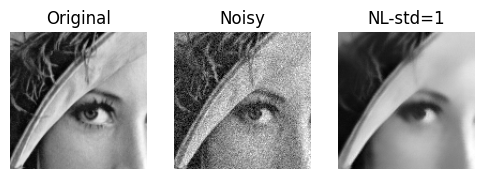

In [19]:
images = [lena_image, noisy_lena_image,nl_denoised_result_st1]
titles = ['Original','Noisy','NL-std=1']


fig, axs = plt.subplots(1, 3, figsize=(6, 2))

# display each image
for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

plt.show()

# Different size for search window and square neighborhood

In [20]:
nl_denoised_result_ps5_wps15 = non_local_means_denoising(noisy_lena_image, ps = 5, wps = 15)

0/127
20/127
40/127
60/127
80/127
100/127
120/127
127/127
Done


In [21]:
nl_denoised_result_ps2_wps7 = non_local_means_denoising(noisy_lena_image, ps = 2, wps = 7)

0/127
20/127
40/127
60/127
80/127
100/127
120/127
127/127
Done


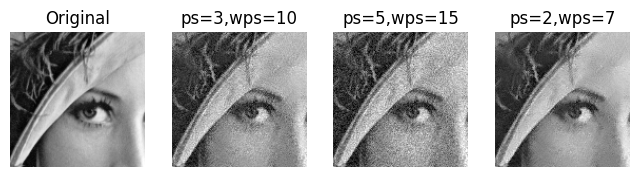

In [22]:
images = [lena_image, nl_denoised_result, nl_denoised_result_ps5_wps15, nl_denoised_result_ps2_wps7]
titles = ['Original', 'ps=3,wps=10','ps=5,wps=15','ps=2,wps=7']


fig, axs = plt.subplots(1, 4, figsize=(8, 2))

# display each image
for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

plt.show()

In [23]:
method_nl_ps2_wps7 = lena_image - nl_denoised_result_ps2_wps7
method_nl_ps5_wps15 = lena_image - nl_denoised_result_ps5_wps15

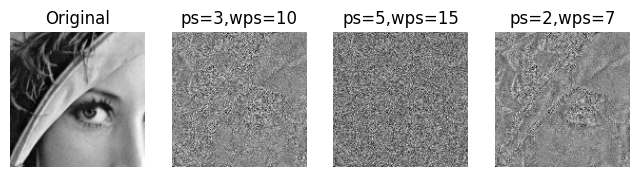

In [24]:
images = [lena_image, method_nl, method_nl_ps5_wps15 ,method_nl_ps2_wps7]
titles = ['Original', 'ps=3,wps=10','ps=5,wps=15','ps=2,wps=7']

fig, axs = plt.subplots(1, 4, figsize=(8, 2))

# display each image
for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

plt.show()

# Means squared error (MSE)

In [25]:
mse_original_vs_NL_st06 = np.mean((lena_image - nl_denoised_result)**2)
mse_original_vs_gaussian_st20 = np.mean((lena_image - gaussian_blurred_lena_image)**2)
mse_original_vs_tv_w25 = np.mean((lena_image - tv_denoised)**2)

In [26]:
mse_original_vs_NL_ps2_wps7 = np.mean((lena_image - nl_denoised_result_ps2_wps7)**2)

In [27]:
from tabulate import tabulate
# Create a table
table_data = [["Image", "GF", "TV","NL st=0.6, ps=3, wps=10","NL st=0.6, ps=2, wps=7"],
              ["Lena",mse_original_vs_gaussian_st20, mse_original_vs_tv_w25, mse_original_vs_NL_st06,mse_original_vs_NL_ps2_wps7]]

# Display the table
table = tabulate(table_data, headers="firstrow", tablefmt="grid")
print(table)

+---------+---------+---------+---------------------------+--------------------------+
| Image   |      GF |      TV |   NL st=0.6, ps=3, wps=10 |   NL st=0.6, ps=2, wps=7 |
+=========+=========+=========+===========================+==========================+
| Lena    | 162.429 | 81.8857 |                   218.385 |                  117.131 |
+---------+---------+---------+---------------------------+--------------------------+
